<a href="https://colab.research.google.com/github/emaudealtema/Data-Mining/blob/main/Copy_of_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import gc
import re
import random
import string
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

import plotly.express as px
import plotly.figure_factory as ff
from plotly import graph_objs as go

from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import spacy
from spacy.util import minibatch
from nltk.corpus import stopwords
from spacy.util import compounding

import warnings
warnings.filterwarnings("ignore")

_ = nltk.download("stopwords")


from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv("../content/drive/MyDrive/Dataset/subjects-questions.csv")
df = df[df["Subject"] != "English"].reset_index(drop=True)
df

eng    Subject
0       An anti-forest measure is\nA. Afforestation\nB...    Biology
1       Among the following organic acids, the acid pr...  Chemistry
2       If the area of two similar triangles are equal...      Maths
3       In recent year, there has been a growing\nconc...    Biology
4       Which of the following statement\nregarding tr...    Physics
...                                                   ...        ...
122514  Which of the following group of\ncharacters is...    Biology
122515  Light year is the\nA. light emitted by the sun...    Physics
122516  Member of Dipnoi are native of\nA. India.\nB. ...    Biology
122517  In one average-life,\nA. half the active nucle...    Physics
122518  State whether true or false.\nA magnetic field...    Physics

[122519 rows x 2 columns]

In [ ]:

df.describe()

eng  Subject
count              122519   122519
unique             121679        4
top     Match the column.  Physics
freq                   12    38438

In [ ]:
data.describe()

eng  Subject
count              122519   122519
unique             121679        4
top     Match the column.  Physics
freq                   12    38438

In [ ]:
#Remove all rows wit NULL values from the DataFrame
df = df.dropna()

Définissons quelques fonctions qui vont nous être utiles

In [ ]:
def func(pct, allvalues):
    absolute = int(pct /100.*np.sum(allvalues))
    return "{:.1f}%".format(pct)
    pass


In [ ]:
def remove_single_word_num(sent):
    '''
    Ayant des fonctions mathématique et d'autre données de format incompréhensible, on les enlève
    les nombre et les mots de format "x + 23 y - abc" pour devenir comme "+ - abc"
    '''
    dummy_list = []
  
    for token in sent.split():
        if (not token.isdigit()) and ((token.isalpha() and len(token)>1) or (not token.isalnum())):
            dummy_list.append(token)   
  
    return ' '.join(dummy_list)


In [ ]:
def preprocess(a):
    # convert the characters into lower case
    a = a.lower()

    # remomve newline character
    a = re.sub("\\n", " ", a)

    # remove the pattern [ whatever here ]. Use { } or  ( ) in place of [ ] in regex
    a = re.sub(r"\[(.*?)\]",' ',a)

    # remove Questions beginners Q5. 5. question 5. 
    a = re.sub(r"^[\w]+(\s|\.)(\s|\d+(\.*(\d+|\s)))\s*", " ", a)

    # remove MathPix markdown starting from \( and ending at \) while preserving data inside \text { preserve this }
    a = re.sub(r'\s*\\+\((.*?)\\+\)', lambda x: " ".join(re.findall(r'\\[a-z]{3,}\s*{([^{}]*)}', x.group(1))), repr(a))

    # remove options from questions i.e character bounded by () given there is no spacing inside ()
    a = re.sub(r"\s*\([^)\s]*\)\s*", " ", a)

    # remove any repeating special character (more than one times) except \(){}[] and space.  So it'll remove .. ,, ___ +++ etc
    a = re.sub(r"([^a-zA-Z0-9\\ (){}\]\[])\1{1,}",' ',a)

    # remove data inside {} -> at max 2 characters {q.}, {5.}
    a = re.sub(r"{.{0,2}}", " ", a)

    # Insert spaces among spec chars, digits and nums  and then remove every single len alphabet and number
    a = remove_single_word_num(insert_spaces(a))

    # remove whatever comes after \\ double slashes except space 
    a = re.sub(r"(\\[^ ]+)",' ',a)

    #remove every special characcter
    a = re.sub(r'(\W)|([_])',' ',a)

    # remomve newline character
    a = re.sub("\\n", " ", a)

    # remove repeated space if there is any
    a = re.sub(r"\s+", " ", a)
  
    return a

In [ ]:
# remove punctuation from each word
import string
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in words]
print(stripped[:100])

['engSubject', 'An', 'antiforest', 'measure', 'is', 'A', 'Afforestation', 'B', 'Selective', 'grazing', 'C', '', 'Clearing', 'forest', 'D', 'Selective', 'fellingBiology', 'Among', 'the', 'following', 'organic', 'acids', 'the', 'acid', 'present', 'in', 'rancid', 'butter', 'is', 'A', '', 'pyruvic', 'acid', 'B', 'lactic', 'acid', 'c', 'butyric', 'acid', 'D', 'acetic', 'acidChemistry', 'If', 'the', 'area', 'of', 'two', 'similar', 'triangles', 'are', 'equal', 'then', 'they', 'are', 'A', '', 'equilateral', 'B', 'isosceles', 'c', 'congruent', 'D', 'not', 'congruentMaths', 'In', 'recent', 'year', 'there', 'has', 'been', 'a', 'growing', 'concern', 'about', 'the', 'gradually', 'increasing', 'average', 'global', 'temperatures', 'If', 'this', 'trend', 'continues', 'would', 'you', 'expert', 'the', 'distributional', 'range', 'of', 'some', 'species', 'to', 'be', 'affectedBiology', 'Which', 'of', 'the', 'following']


In [ ]:
filename = '/content/drive/MyDrive/Dataset/subjects-questions.csv'
file = open(filename, 'rt')
text = file.read()
file.close()
# split into words by white space
words = text.split()
print(words[:100])

['eng,Subject', '"An', 'anti-forest', 'measure', 'is', 'A.', 'Afforestation', 'B.', 'Selective', 'grazing', 'C', '.', 'Clearing', 'forest', 'D.', 'Selective', 'felling",Biology', '"Among', 'the', 'following', 'organic', 'acids,', 'the', 'acid', 'present', 'in', 'rancid', 'butter', 'is:', 'A', '.', 'pyruvic', 'acid', 'B.', 'lactic', 'acid', 'c.', 'butyric', 'acid', 'D.', 'acetic', 'acid",Chemistry', '"If', 'the', 'area', 'of', 'two', 'similar', 'triangles', 'are', 'equal,', 'then', 'they', 'are', 'A', '.', 'equilateral', 'B.', 'isosceles', 'c.', 'congruent', 'D.', 'not', 'congruent",Maths', '"In', 'recent', 'year,', 'there', 'has', 'been', 'a', 'growing', 'concern', 'about', 'the', 'gradually', 'increasing', 'average', 'global', 'temperatures.', 'If', 'this', 'trend', 'continues,', 'would', 'you', 'expert', 'the', 'distributional', 'range', 'of', 'some', 'species', 'to', 'be', 'affected?",Biology', '"Which', 'of', 'the', 'following']


In [ ]:
# split into words
from nltk.tokenize import word_tokenize
tokens = word_tokenize(text)
print(tokens[:100])

['eng', ',', 'Subject', "''", 'An', 'anti-forest', 'measure', 'is', 'A.', 'Afforestation', 'B', '.', 'Selective', 'grazing', 'C', '.', 'Clearing', 'forest', 'D.', 'Selective', 'felling', "''", ',', 'Biology', "''", 'Among', 'the', 'following', 'organic', 'acids', ',', 'the', 'acid', 'present', 'in', 'rancid', 'butter', 'is', ':', 'A', '.', 'pyruvic', 'acid', 'B.', 'lactic', 'acid', 'c.', 'butyric', 'acid', 'D.', 'acetic', 'acid', "''", ',', 'Chemistry', "''", 'If', 'the', 'area', 'of', 'two', 'similar', 'triangles', 'are', 'equal', ',', 'then', 'they', 'are', 'A', '.', 'equilateral', 'B.', 'isosceles', 'c.', 'congruent', 'D.', 'not', 'congruent', "''", ',', 'Maths', "''", 'In', 'recent', 'year', ',', 'there', 'has', 'been', 'a', 'growing', 'concern', 'about', 'the', 'gradually', 'increasing', 'average', 'global', 'temperatures']


In [ ]:
# stemming of words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
stemmed = [porter.stem(word) for word in tokens]
print(stemmed[:100])

['eng', ',', 'subject', "''", 'an', 'anti-forest', 'measur', 'is', 'a.', 'afforest', 'b', '.', 'select', 'graze', 'c', '.', 'clear', 'forest', 'd.', 'select', 'fell', "''", ',', 'biolog', "''", 'among', 'the', 'follow', 'organ', 'acid', ',', 'the', 'acid', 'present', 'in', 'rancid', 'butter', 'is', ':', 'a', '.', 'pyruv', 'acid', 'b.', 'lactic', 'acid', 'c.', 'butyr', 'acid', 'd.', 'acet', 'acid', "''", ',', 'chemistri', "''", 'if', 'the', 'area', 'of', 'two', 'similar', 'triangl', 'are', 'equal', ',', 'then', 'they', 'are', 'a', '.', 'equilater', 'b.', 'isoscel', 'c.', 'congruent', 'd.', 'not', 'congruent', "''", ',', 'math', "''", 'in', 'recent', 'year', ',', 'there', 'ha', 'been', 'a', 'grow', 'concern', 'about', 'the', 'gradual', 'increas', 'averag', 'global', 'temperatur']


In [ ]:
def plot_barchart(title=None):
        fig = px.bar(temp, x="count", y="Common_words", title=title, orientation='h', 
                 width=700, height=700, color='Common_words')
        fig.show()
        pass
    
    # plot_barchart(title)
        if return_temp:
          return temp
    
          del temp, top
          _ = gc.collect()
    
          pass

In [ ]:
def plot_wordcloud(text, mask=None, max_words=250, max_font_size=100, figure_size=(24.0,16.0), color = 'black',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    pass

In [ ]:
import pandas as pd
data.dropna(subset=["eng"], inplace=True)
data.reset_index(inplace=True, drop=True)
data.isna().sum().to_frame().rename(columns={0:"NaN_Count"}).style.background_gradient(cmap="Wistia")

Nottre objectif est de classifier une description, ayant 4 classes: chimie, math, physique et biologie, on doit pouvoir classifier une description disant ainsi si à quelle classe elle appartient. 

In [ ]:
def common_tokens(data, col, top_most=50, title=None, return_temp=False, is_top=True):
     
    top = Counter([item for sublist in data[col] for item in sublist])
    if not is_top:
        temp = pd.DataFrame(top.most_common()[:-top_most:-1])
    else:
        temp = pd.DataFrame(top.most_common(top_most))
    temp.columns = ['Common_words','count']
    display(temp.style.background_gradient(cmap='Blues'))
    
    def plot_barchart(title=None):
        fig = px.bar(temp, x="count", y="Common_words", title=title, orientation='h', 
                 width=700, height=700, color='Common_words')
        fig.show()
        pass
    
    # plot_barchart(title)
    if return_temp:
        return temp
    
    del temp, top
    _ = gc.collect()
    
    pass


# free up space
del target_Count
_ = gc.collect()

In [ ]:
def func(pct, allvalues):
    absolute = int(pct /100.*np.sum(allvalues))
    return "{:.1f}%".format(pct)
    pass


def remove_single_word_num(sent):
    '''
    Remove numbers and words of single length such as "x + 23 y - abc" will become "+ - abc"
    '''
    dummy_list = []
  
    for token in sent.split():
        if (not token.isdigit()) and ((token.isalpha() and len(token)>1) or (not token.isalnum())):
            dummy_list.append(token)   
  
    return ' '.join(dummy_list)

In [ ]:
def func(pct, allvalues):
    absolute = int(pct /100.*np.sum(allvalues))
    return "{:.1f}%".format(pct)
    pass

In [ ]:
target_Count = data['Subject'].value_counts().to_frame()
target_Count.style.background_gradient(cmap="BrBG")

In [ ]:
# free up space
del target_Count
_ = gc.collect()

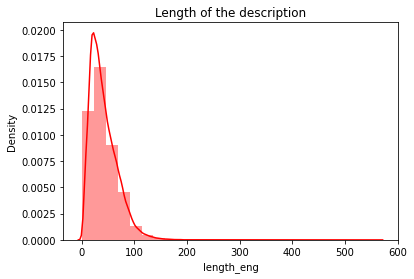

In [ ]:
#regardons la longueur d<une description.
df["length_eng"] = df['eng'].apply(lambda x: len(x.split()))
sns.distplot(df["length_eng"], color="red", bins=25)
plt.title("Length of the description")
plt.show()


On constate que les longueur des donnees sont faussées à gauche. 
, allons regarder les outliers(données aberrantes) via des bars plot.

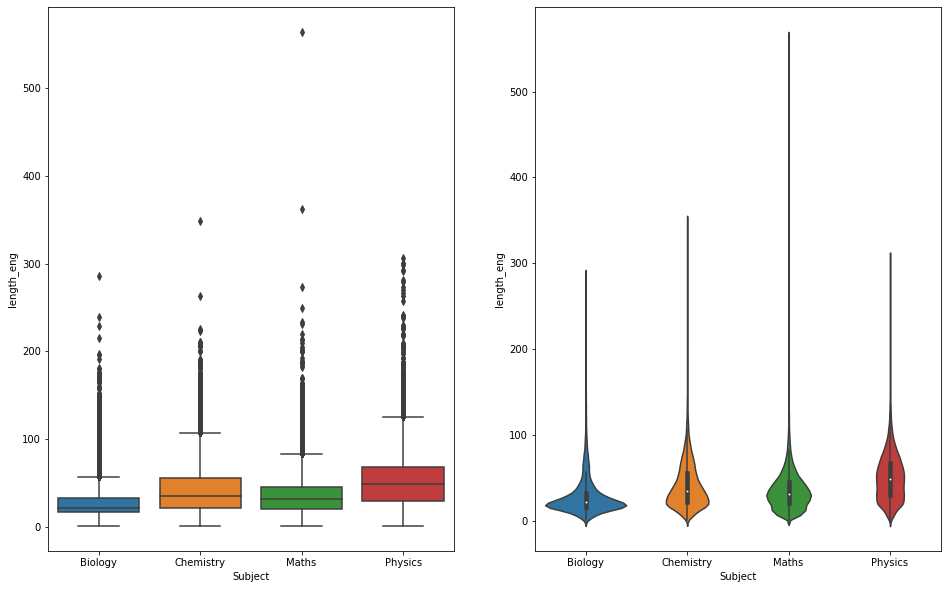

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
sns.boxplot(x="Subject", y="length_eng", data=df, ax=ax1)
sns.violinplot(x="Subject", y="length_eng", data=df, ax=ax2)
plt.show()

Il y a des aberrations, trop d'aberrations dans la longueur notre colonne. Les conclusions de ces graphiques sont les suivantes :

Les questions de physique sont plus longues et les questions de biologie sont plus courtes.
La biologie semble avoir moins de valeurs aberrantes, ce qui indique que la plupart des questions de biologie sont proches de leur valeur médiane, avec seulement quelques valeurs aberrantes. La variance est moindre.
La physique semble avoir la variance la plus élevée avec la médiane la plus basse.
La chimie a la description la plus longue, mais la variance n'est pas si grande, ce qui indique qu'un nombre important d'échantillons se situent autour de la valeur médiane. Il en va de même pour les mathématiques, avec une valeur de description la plus longue plus faible.



Analysons statistiquement la longueur

In [ ]:
pct_25 = lambda x: np.percentile(x, 25)
pct_75 = lambda x: np.percentile(x, 75)
pct_75.__name__ = "75%"
pct_25.__name__ = "25%"

In [ ]:
# l'analyse ici ne prend en compte des données prétraitées
df.pivot_table("length_eng", "Subject", aggfunc=["count", "min", pct_25, "mean", "median", pct_75, "max", "std", "var"]).style.background_gradient(cmap="plasma")

In [ ]:
display(df)

eng    Subject  \
0       An anti-forest measure is\nA. Afforestation\nB...    Biology   
1       Among the following organic acids, the acid pr...  Chemistry   
2       If the area of two similar triangles are equal...      Maths   
3       In recent year, there has been a growing\nconc...    Biology   
4       Which of the following statement\nregarding tr...    Physics   
...                                                   ...        ...   
122514  Which of the following group of\ncharacters is...    Biology   
122515  Light year is the\nA. light emitted by the sun...    Physics   
122516  Member of Dipnoi are native of\nA. India.\nB. ...    Biology   
122517  In one average-life,\nA. half the active nucle...    Physics   
122518  State whether true or false.\nA magnetic field...    Physics   

        length_eng  
0               16  
1               25  
2               22  
3               32  
4               76  
...            ...  
122514          51  
122515          49  
122516          20  
122517          30  
122518          24  

[122519 rows x 3 columns]

In [ ]:
for _ in range(5):
    print(df.loc[np.random.randint(0, len(df)), "eng"])

The capacity between the adjacent plates of a parallel plate capacitor is \( 10 \mu F . \) If we want a capacity of \( 50 \mu F \) the number of plates to be used is
A. 5
B. 50
\( c \cdot 6 \)
\( D \)
Solve graphically the following pairs of
equations
\( 4 x-y-5=0 ; x+y-5=0 \)
\( \mathbf{A} \cdot(2,3) \)
B \( \cdot(3,3) \)
\( \mathbf{c} \cdot(4,3) \)
D. None of these
The time taken by a particle performing
SHM to pass from point \( A \) to \( B \) where
its velocities are same is 2 s. After
another \( 2 s \) it returns to \( B \). The ratio of
distance \( O B \) to its amplitude (where \( O \)
is the mean position) is :
A. \( 1: \sqrt{2} \)
B . \( (\sqrt{2}-1): 1 \)
c. 1: 2
D. \( 1: 2 \sqrt{2} \)
Which of the following is not a decomposition reaction?
\( A \cdot \operatorname{cac} 0_{3} \rightarrow \operatorname{cad}+\cos \)
В. \( 2 \mathrm{KClO}_{3} \rightarrow 2 \mathrm{KCl}+3 \mathrm{O}_{2} \)
c. Digestion of food in the body
D. NaOH+HCI \( \rightarrow \) Nacl + Hz
Statement I: \( _

Comme nous pouvons le constater, la plupart des questions contiennent des options telles que (a), (b), (i), etc. Bien sûr, nous trouverons de telles options dans chaque matière. Comme notre but est de construire un classificateur pour classifier qu'une question ou une description donnée appartient à un sujet particulier, garder ces jetons n'apportera qu'une similarité réductrice, donc supprimons-les et appliquons un prétraitement de base pour avancer dans notre exploration


In [ ]:
for _ in range(25):
    print("\n")
    i = np.random.randint(0, len(df))
    x, y = df.loc[i, "eng"], df.loc[np.random.randint(0, len(df)), "Subject"]
    print(x)
    print()
    print(y, "\t", i, "\n")
    print(preprocess(x))



is the electrical charges generated by rubbing.
A. electricity
B. static charge
\( c . \) both a and \( b \)
D. none of the above

Physics 	 66834 

 is the electrical charges generated by rubbing electricity static charge both and none of the above 


The magnetic moment of \( \left[N i X_{4}\right]^{2-} \) ion
is found to be zero. Then the metal of the
complex ion is \( (X= \) monodentate anionic ligand ).
A \( \cdot s p^{3} \) hybridised
B \( \cdot s p d^{2} \) hybridised
c. \( d s p^{2} \) hybridised
D. \( d^{2}^{2} p \) hybridised

Chemistry 	 3700 

 the magnetic moment of ion is found to be zero then the metal of the complex ion is monodentate anionic ligand hybridised hybridised hybridised hybridised 


The displacement of centre of mass of
\( A+B \) system till the string becomes
vertical is :
A. zer
в. \( \frac{L}{2}(1-\cos \theta) \)
c \( \cdot \frac{L}{2}(1-\sin \theta) \)
D. none of these

Biology 	 96138 

 the displacement of centre of mass of system till the string be

In [ ]:
df["processed_eng"] = df["eng"].apply(lambda x: preprocess(x))
display(df.head())

eng    Subject  length_eng  \
0  An anti-forest measure is\nA. Afforestation\nB...    Biology          16   
1  Among the following organic acids, the acid pr...  Chemistry          25   
2  If the area of two similar triangles are equal...      Maths          22   
3  In recent year, there has been a growing\nconc...    Biology          32   
4  Which of the following statement\nregarding tr...    Physics          76   

                                       processed_eng  \
0   an anti forest measure is afforestation selec...   
1   among the following organic acids the acid pr...   
2   if the area of two similar triangles are equa...   
3   in recent year there has been growing concern...   
4   which of the following statement regarding tr...   

                                token_list_processed  \
0  [an, anti, forest, measure, is, afforestation,...   
1  [among, the, following, organic, acids, the, a...   
2  [if, the, area, of, two, similar, triangles, a...   
3  [in, recent, year, there, has, been, growing, ...   
4  [which, of, the, following, statement, regardi...   

                                          token_list  
0  [An, anti-forest, measure, is, A., Afforestati...  
1  [Among, the, following, organic, acids,, the, ...  
2  [If, the, area, of, two, similar, triangles, a...  
3  [In, recent, year,, there, has, been, a, growi...  
4  [Which, of, the, following, statement, regardi...

In [ ]:
df["token_list"] = df["eng"].apply(lambda x: x.split())
common_tokens(df, col="token_list", top_most=2000)  # experiment with stopwords(removing/not removing)

In [ ]:
#Most common words with Preprocessing
df["token_list_processed"] = df["processed_eng"].apply(lambda x: x.split())
most_2000 = common_tokens(df, col="token_list_processed", top_most=2000, return_temp=True)


In [ ]:
#Least common words without any preprocessing
common_tokens(df, col="token_list", top_most=2000, is_top=False)

In [ ]:
df["token_list"] = df["token_list"].apply(lambda x: remove_stopword(x))
df["token_list_processed"] = df["token_list_processed"].apply(lambda x: remove_stopword(x))



In [ ]:
#Most common words without any preprocessing
common_tokens(df, col="token_list", top_most=2000)

In [ ]:
# Most common word apres le prétraitement
most_2000_sr = common_tokens(df, col="token_list_processed", top_most=2000, return_temp=True)


In [ ]:
df["token_list_processed"] = df["processed_eng"].apply(lambda x: x.split())
most_2000 = common_tokens(df, col="token_list_processed", top_most=2000, return_temp=True)

In [ ]:
#Mots moins commun après le prétraitement
least_2000 = common_tokens(df, col="token_list_processed", top_most=20, is_top=False, return_temp=True)

In [ ]:
#Most common words with preprocessing
most_2000_sr = common_tokens(df, col="token_list_processed", top_most=20, return_temp=True)

In [ ]:
# moins commnuns
least_2000_sr = common_tokens(df, col="token_list_processed", top_most=20, return_temp=True, is_top=False)

In [ ]:
#delete  stop words

df["token_list"] = df["token_list"].apply(lambda x: remove_stopword(x))
df["token_list_processed"] = df["token_list_processed"].apply(lambda x: remove_stopword(x))

In [ ]:
Phy = df[df['Subject']=='Physics']
Math = df[df['Subject']=='Maths']
Chem = df[df['Subject']=='Chemistry']
Bio = df[df['Subject']=='Biology']

In [ ]:
Phy.name = "Phy"
Chem.name = "Chem"
Bio.name = "Bio"
Math.name = "Math"

20 monts plus communs et 20 mots moins connus en Chimie

In [ ]:
# 20 mots plus communs en chimie
top_Chem = common_tokens(Chem, col="token_list_processed", top_most=20, return_temp=True)


In [ ]:
# mots moins communs en chimie
least_Chem = common_tokens(Chem, col="token_list_processed", top_most=20, return_temp=True, is_top=False)


20 monts plus communs et 20 mots moins connus en physique

In [ ]:
# 20 mots plus communs en physique
top_phy = common_tokens(Phy, col="token_list_processed", top_most=20, return_temp=True)


In [ ]:
# 20 mots moins communs en physique
least_phy = common_tokens(Phy, col="token_list_processed", top_most=20, return_temp=True, is_top=False)


20 monts plus communs et 20 mots moins connus en Math

In [ ]:
#20 mots  les moins commun en Maths

top_math = common_tokens(Math, col="token_list_processed", top_most=20, return_temp=True)



In [ ]:
# 29 mots moins communs en math
least_math = common_tokens(Math, col="token_list_processed", top_most=20, return_temp=True, is_top=False)

20 monts plus communs et 20 mots moins connus en Biologie

In [ ]:
# 20 mots plus communs en Biologie
top_bio = common_tokens(Bio, col="token_list_processed", top_most=20, return_temp=True)

In [ ]:
# 20 mots moins communs en Bio

least_Bio = common_tokens(Bio, col="token_list_processed", top_most=20, return_temp=True, is_top=False)


In [ ]:
# we have dataframes for each subject as well as on the whole set
common_words = pd.concat([most_2000.drop("count", axis=1).rename(columns={"Common_words": "most_common"}),
           most_2000_sr.drop("count", axis=1).rename(columns={"Common_words": "most_common_sr"}),
           least_2000.drop("count", axis=1).rename(columns={"Common_words": "least_common"}),
           least_2000_sr.drop("count", axis=1).rename(columns={"Common_words": "least_common_sr"}),
           top_phy.drop("count", axis=1).rename(columns={"Common_words": "most_phy"}),
           least_Phy.drop("count", axis=1).rename(columns={"Common_words": "least_phy"}),
           top_chem.drop("count", axis=1).rename(columns={"Common_words": "most_chem"}),
           least_Chem.drop("count", axis=1).rename(columns={"Common_words": "least_chem"}),
           top_bio.drop("count", axis=1).rename(columns={"Common_words": "most_bio"}),
           least_Bio.drop("count", axis=1).rename(columns={"Common_words": "least_bio"}),
           top_math.drop("count", axis=1).rename(columns={"Common_words": "most_math"}),
           least_math.drop("count", axis=1).rename(columns={"Common_words": "least_math"})], axis=1)
display(common_words.head())
common_words.to_csv("common-words-analysis.csv", index=False)

most_common most_common_sr      least_common   least_common_sr   most_phy  \
0         the        correct  tetraethylcarbon  tetraethylcarbon    correct   
1          of         reason         neononane         neononane     reason   
2          is      assertion             parta             parta  assertion   
3         and      following    salicyaldehyde    salicyaldehyde        two   
4          in           find         lagranage         lagranage   velocity   

      least_phy  most_chem         least_chem   most_bio    least_bio  \
0      betweenr    correct   tetraethylcarbon    correct      zealand   
1     lagranage     reason          neononane     reason  hydrothorax   
2    decomposed  following     salicyaldehyde  assertion         beet   
3      figurate  assertion  pentaamminentrito  following   rhinobatos   
4  constituents   reaction        arrangments      water      baldder   

   most_math    least_math  
0       find      betweenr  
1      value     lagranage  
2  following    decomposed  
3     number      figurate  
4       none  constituents

Analyse des caractères spéciaux

In [ ]:
special_dict = Counter([item for sublist in df["eng"] for item in sublist if not item.isalnum()])
special_dict = pd.DataFrame(special_dict.most_common())
special_dict_pp = Counter([item for sublist in df["processed_eng"] for item in sublist if not item.isalnum()])
special_dict_pp = pd.DataFrame(special_dict_pp.most_common())

In [ ]:
special_dict.columns = ["Special_tokens", "count"]
special_dict_pp.columns = ["Special_tokens", "count"]

In [ ]:
for ddf in [Phy, Chem, Bio, Math]:
    
    special_ = Counter([item for sublist in ddf["eng"] for item in sublist if not item.isalnum()])
    special_ = pd.DataFrame(special_.most_common())
    special_.columns = ["Special_tokens", ddf.name]

    special_dict = pd.merge(special_dict, special_, how="left", on="Special_tokens")
    special_dict[ddf.name] = special_dict[ddf.name].fillna(0).astype("int64")
    
special_dict

Special_tokens    count      Phy     Chem     Bio     Math
0                  4413966  1732076  1344822  311918  1025150
1               \  1284777   418740   347770   21312   496955
2               {   599369   164469   193846    6260   234794
3               }   598979   164463   193835    6260   234421
4              \n   574188   203978   187469   57263   125478
5               .   462095   173853   151271   52524    84447
6               )   456396   148473   136507   11599   159817
7               (   454170   147834   135431   11381   159524
8               -   119759    27850    39022    7944    44943
9               _   119387    27025    78717    1692    11953
10              ^   115792    36679    31899     653    46561
11              ,   115527    29814    28722   10008    46983
12              +    64614     6985    18591     615    38423
13              =    57910    14914     9034     162    33800
14              :    39277    12587    18144     881     7665
15              ?    29553     8751    12624    3882     4296
16              /    20380    12362     4171     412     3435
17              &    19145     2199     2000    1358    13588
18              [    11629     1418     5604      20     4587
19              ]    11297     1312     5516      18     4451
20              |     9545      925     1818     185     6617
21              '     9491     4679     2801     892     1119
22              >     7809     1348     5250      63     1148
23              <     6568     1055     3664      46     1803
24              %     6090     1476     2115     457     2042
25              ;     3970      861     1652     422     1035
26              "     1100      283      266     175      376
27              !      692       15       24      20      633
28              $      464      151       90      12      211
29              ॥      464       82      278      80       24
30              ।      419       76      253      69       21
31              *      382       18       89       5      270
32              ~      290      151       85       0       54
33              ・      230       87       46       0       97
34              ¡      205       41      117      16       31
35              ±       68        4        1       0       63
36              ा       59        9       32      16        2
37              #       27        1       20       0        6
38              」       25       15       10       0        0
39              €        6        4        0       1        1
40              ्        4        1        2       0        1
41              ）        3        0        3       0        0
42              ¿        3        3        0       0        0
43              @        3        0        2       0        1
44              《        2        1        1       0        0
45              。        2        0        0       0        2
46              ₹        2        0        0       0        2
47              ू        1        1        0       0        0
48              ้        1        1        0       0        0
49              £        1        1        0       0        0
50              ॰        1        1        0       0        0
51              ि        1        0        1       0        0
52              ่        1        0        1       0        0
53              ิ        1        1        0       0        0
54              े        1        0        1       0        0

In [ ]:
display(special_dict.style.background_gradient(cmap="twilight_shifted"))

In [ ]:
special_dict.to_csv("special-characters-analysis.csv", index=False)

Affichage des wordcloud pour chacune de nos classes

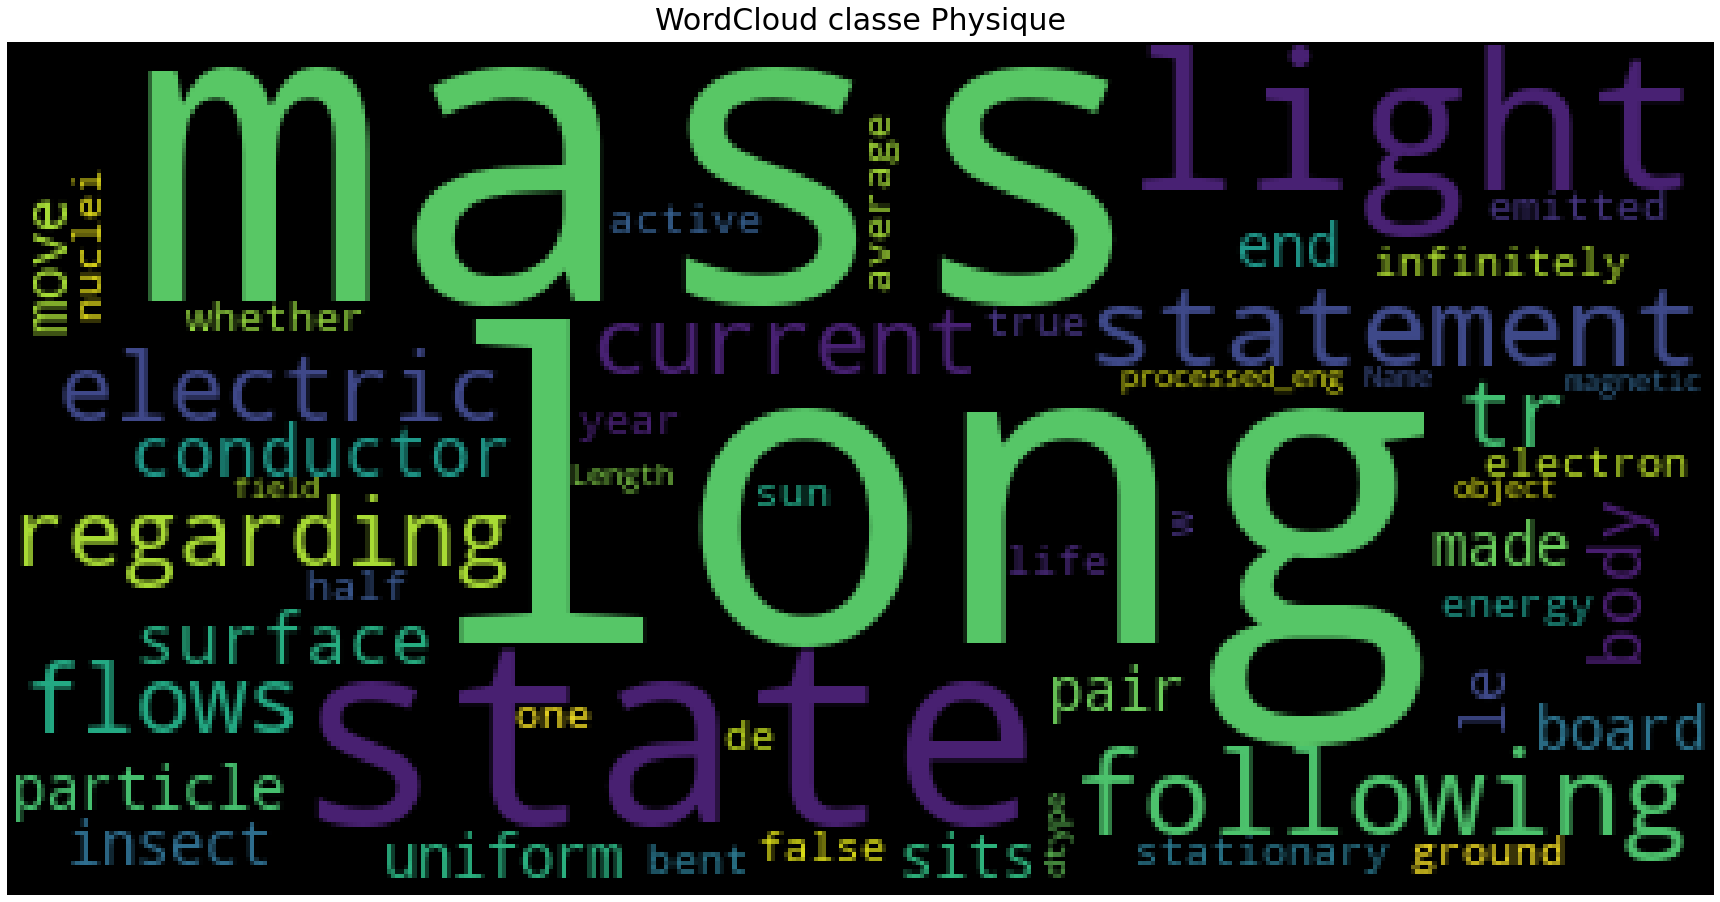

In [ ]:
plot_wordcloud(Phy.processed_eng, color='black', max_font_size=100, title_size=30, title="WordCloud classe Physique")

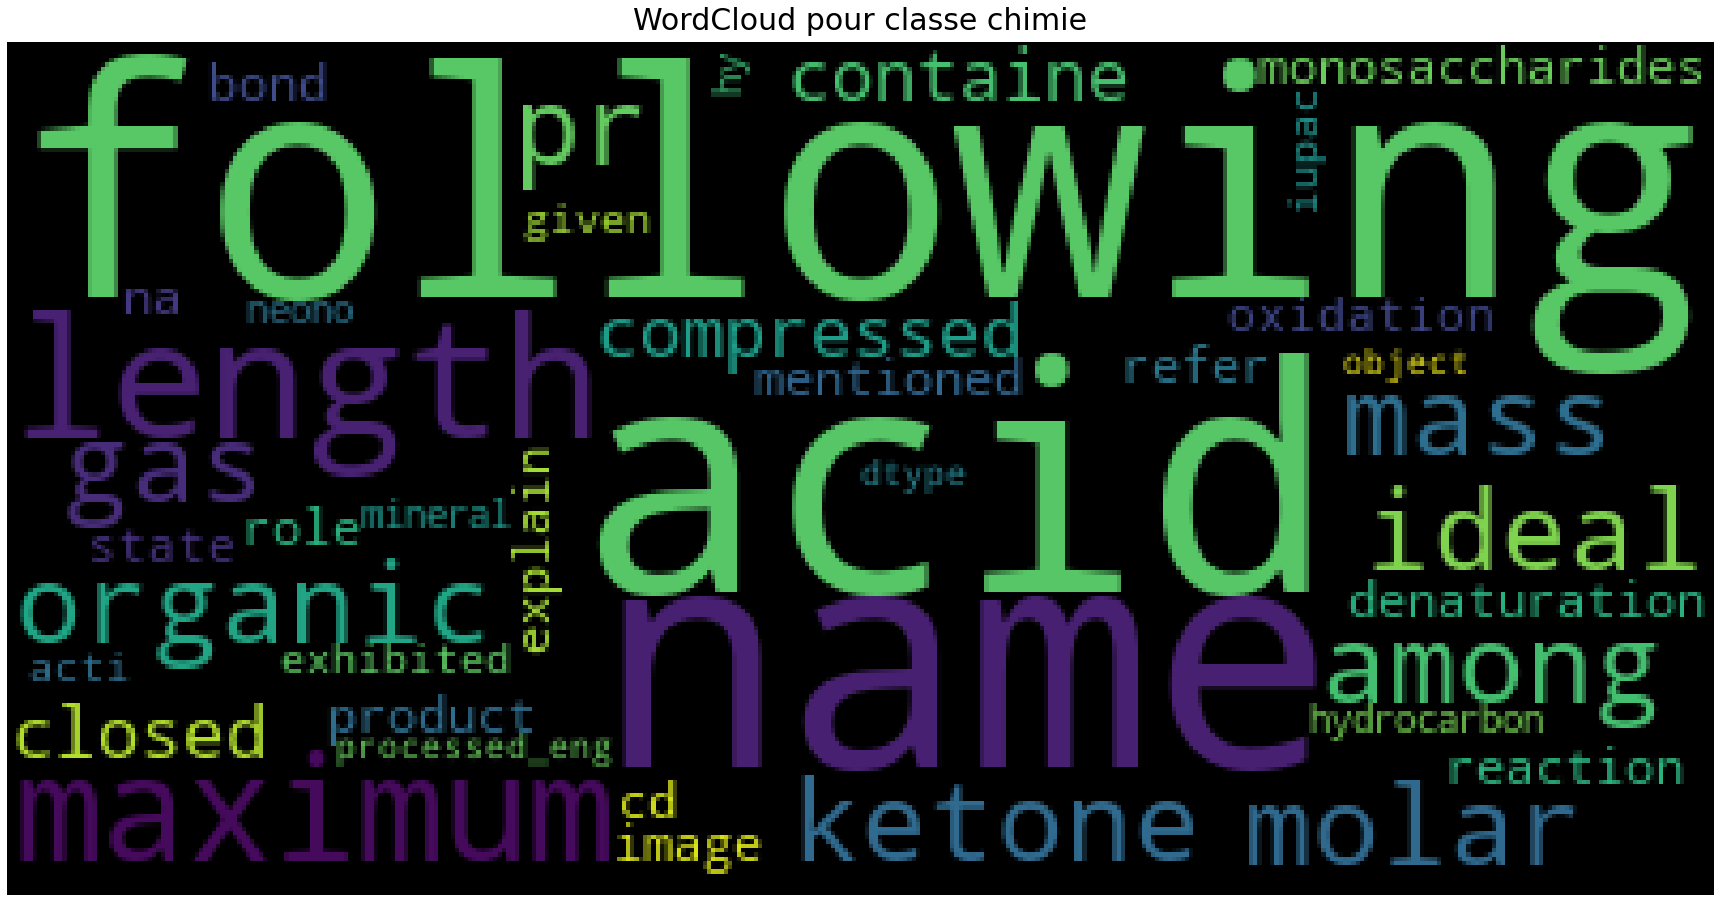

In [ ]:
plot_wordcloud(Chem.processed_eng, color='black', max_font_size=100, title_size=30, title="WordCloud pour classe chimie")

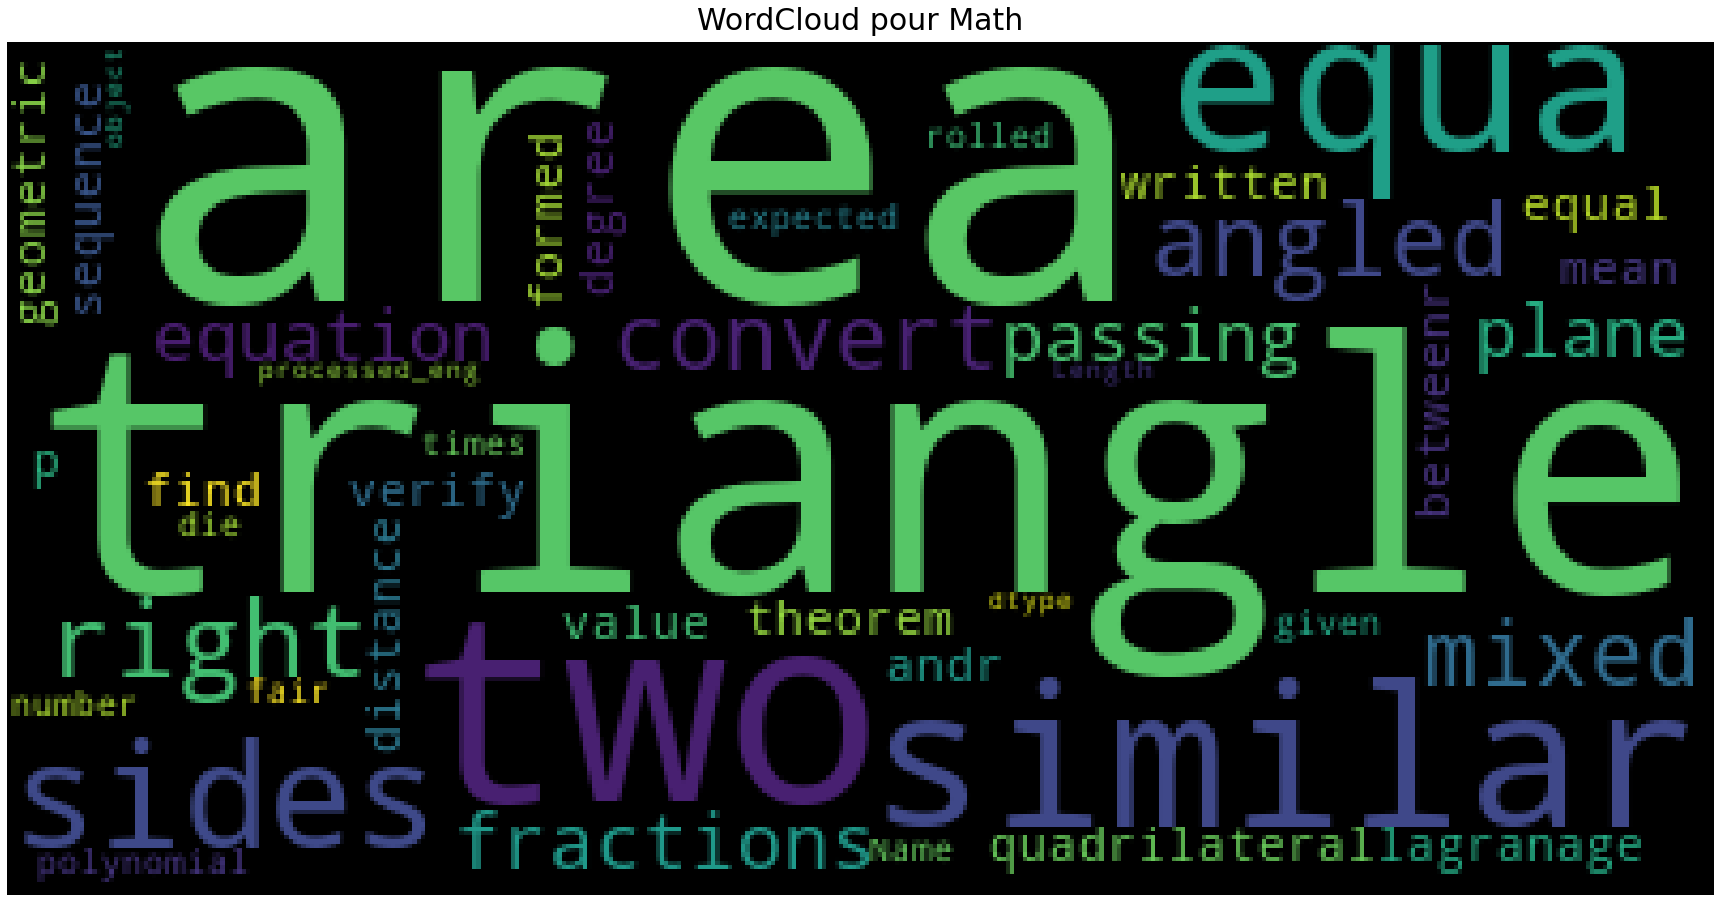

In [ ]:
plot_wordcloud(Math.processed_eng, color='black', max_font_size=100, title_size=30, title="WordCloud pour Math")

Référence du tuto (https://www.kaggle.com/code/mrutyunjaybiswal/toughest-subject-in-exams-phy-or-math-or-chem)

[ULTRON]· UPDATED 2 YEARS AGO